### Library Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import time
import os
import cv2
from PIL import Image

from IPython.display import display, Image
from tqdm import tqdm

%matplotlib inline

In [2]:
data = pd.read_csv('./ODIR-5K/data.csv')
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [3]:
data.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O'],
      dtype='object')

In [4]:
def basic_eda(df, name):
    print(f"""---------------------------------------\n
{name.upper()} dataframe \n
Rows: {df.shape[0]}             Columns: {df.shape[1]}
Duplicated rows: {(df.duplicated(keep=False) == True).sum()}
Columns:
{pd.concat([pd.DataFrame(data=df.dtypes, columns=['data_type']),
         pd.DataFrame(data=df.isnull().sum(), columns=['num_nulls']),
         pd.DataFrame(data=df.notnull().sum(), columns=['num_not_nulls']),
         pd.DataFrame(data=df.nunique(), columns=['unique_values']),
         
         ], axis=1)}
    \n""")
print("DATAFRAME INFORMATION")    

#call function    
basic_eda(data, "Fundus Imaging")

DATAFRAME INFORMATION
---------------------------------------

FUNDUS IMAGING dataframe 

Rows: 3500             Columns: 15
Duplicated rows: 0
Columns:
                          data_type  num_nulls  num_not_nulls  unique_values
ID                            int64          0           3500           3500
Patient Age                   int64          0           3500             75
Patient Sex                  object          0           3500              2
Left-Fundus                  object          0           3500           3500
Right-Fundus                 object          0           3500           3500
Left-Diagnostic Keywords     object          0           3500            227
Right-Diagnostic Keywords    object          0           3500            233
N                             int64          0           3500              2
D                             int64          0           3500              2
G                             int64          0           3500              2


In [5]:
feat_l = ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Left-Diagnostic Keywords']
feat_r = ['ID', 'Patient Age', 'Patient Sex', 'Right-Fundus', 'Right-Diagnostic Keywords']
# {'Left-Fundus': 'Left-Fundus', 'Left-Diagnostic Keywords': 'Diagnostic Keywords'}
data_l = data[feat_l].rename(columns= {'Left-Fundus': 'Fundus',
                                       'Left-Diagnostic Keywords': 'Diagnostic Keywords'})
data_l['oculus'] = "L"
data_r = data[feat_r].rename(columns= {'Right-Fundus': 'Fundus',
                                       'Right-Diagnostic Keywords': 'Diagnostic Keywords'})
data_r['oculus'] = "R"
data_new = pd.concat([data_l, data_r], axis=0)

In [6]:
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus
0,0,69,Female,0_left.jpg,cataract,L
1,1,57,Male,1_left.jpg,normal fundus,L
2,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L
3,3,66,Male,3_left.jpg,normal fundus,L
4,4,53,Male,4_left.jpg,macular epiretinal membrane,L


In [7]:
data_new.sort_values('ID', ignore_index=True, inplace=True)

In [8]:
data_new.to_csv('./assets/data_new_binary_v1.csv', index=False)

In [9]:
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus
0,0,69,Female,0_left.jpg,cataract,L
1,0,69,Female,0_right.jpg,normal fundus,R
2,1,57,Male,1_left.jpg,normal fundus,L
3,1,57,Male,1_right.jpg,normal fundus,R
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L


In [10]:
data_new = pd.read_csv('./assets/data_new_binary_v1.csv')

In [11]:
#label normal if keyword contains normal
data_new['abnormal'] = data_new['Diagnostic Keywords'].str.contains('normal', regex=False)

In [12]:
#convert to alphanumeric values
data_new['abnormal'] = data_new['abnormal'].map({True: "0", False: "1"})

In [13]:
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,abnormal
0,0,69,Female,0_left.jpg,cataract,L,1
1,0,69,Female,0_right.jpg,normal fundus,R,0
2,1,57,Male,1_left.jpg,normal fundus,L,0
3,1,57,Male,1_right.jpg,normal fundus,R,0
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L,1


In [14]:
basic_eda(data_new, "Fundus Imaging")

---------------------------------------

FUNDUS IMAGING dataframe 

Rows: 7000             Columns: 7
Duplicated rows: 0
Columns:
                    data_type  num_nulls  num_not_nulls  unique_values
ID                      int64          0           7000           3500
Patient Age             int64          0           7000             75
Patient Sex            object          0           7000              2
Fundus                 object          0           7000           7000
Diagnostic Keywords    object          0           7000            329
oculus                 object          0           7000              2
abnormal               object          0           7000              2
    



In [15]:
img_src = []
img_dir = './ODIR-5K/color_fundus/'

counter = 0
for subdir, dirs, files in os.walk(img_dir):
    for file in files:
        full_path = os.path.join(subdir, file)
        dict_img = {}
        dict_img['filepath'] = full_path
        dict_img['Fundus'] = file
        img_src.append(dict_img)
        counter = counter + 1
        if counter %1000 == 0:
            print(f"{counter} images")
print(f"Done! ")

1000 images
2000 images
3000 images
4000 images
5000 images
6000 images
7000 images
Done! 


In [16]:
data_new = pd.merge(data_new, pd.DataFrame(img_src), on='Fundus')
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,abnormal,filepath
0,0,69,Female,0_left.jpg,cataract,L,1,./ODIR-5K/color_fundus/0_left.jpg
1,0,69,Female,0_right.jpg,normal fundus,R,0,./ODIR-5K/color_fundus/0_right.jpg
2,1,57,Male,1_left.jpg,normal fundus,L,0,./ODIR-5K/color_fundus/1_left.jpg
3,1,57,Male,1_right.jpg,normal fundus,R,0,./ODIR-5K/color_fundus/1_right.jpg
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L,1,./ODIR-5K/color_fundus/2_left.jpg


In [17]:
data_new.to_csv('./assets/data_new_binary_v2.csv', index=False)

In [18]:
df = pd.read_csv('./assets/data_new_binary_v2.csv')

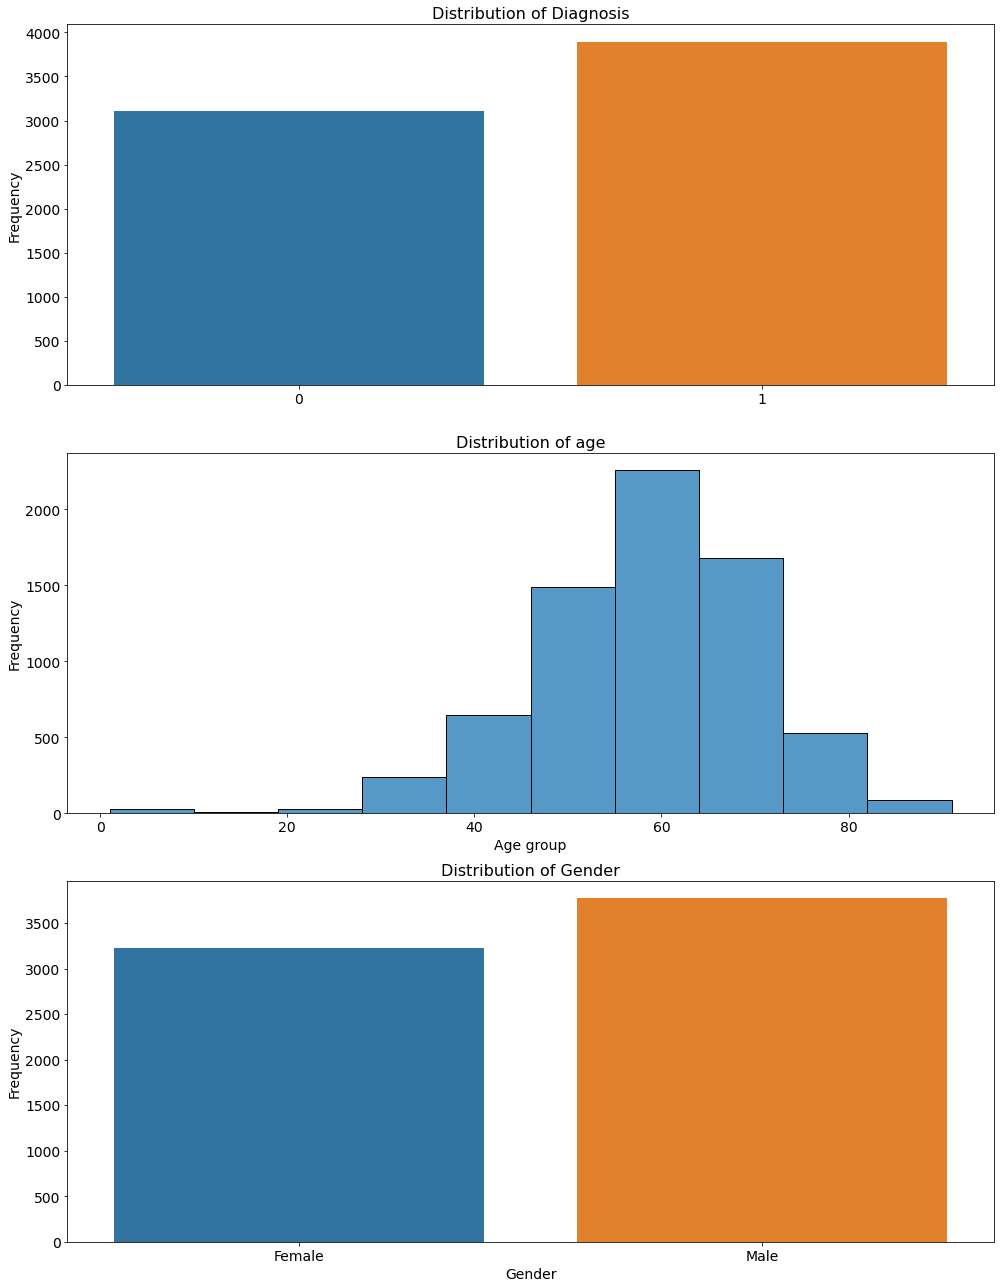

In [19]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (14, 18))

sns.barplot(x=df['abnormal'].value_counts(ascending=True).index,
            y=df['abnormal'].value_counts(ascending=True).values,
            ax=ax[0])
ax[0].set_title('Distribution of Diagnosis', fontsize=16)
ax[0].set_ylabel('Diagnosis', fontsize=14)
ax[0].set_ylabel('Frequency', fontsize=14)
ax[0].tick_params(axis='both', labelsize=14)


sns.histplot(x=df['Patient Age'].sort_values(),bins=10,ax=ax[1])
ax[1].set_title('Distribution of age', fontsize=16)
ax[1].set_xlabel('Age group', fontsize=14)
ax[1].set_ylabel('Frequency', fontsize=14)
ax[1].tick_params(axis='both', labelsize=14)

sns.countplot(x=df['Patient Sex'].sort_values(), ax=ax[2])
ax[2].set_title('Distribution of Gender', fontsize=16)
ax[2].set_xlabel('Gender', fontsize=14)
ax[2].set_ylabel('Frequency', fontsize=14)
ax[2].tick_params(axis='both', labelsize=14)


plt.tight_layout();

In [20]:
#wordcloud on keywords

In [21]:
#images not labelled due to low quality
low_qual_index = df[(df['Diagnostic Keywords'].str.contains('low', regex=False))].index[2:]

In [25]:
#dropping rows
df = df.drop(index= low_qual_index)
df.shape

KeyError: '[ 743 5659 5681 5778 5882 5989 6030 6031 6064 6084 6116 6240 6295 6352\n 6488 6548 6576 6586 6709 6859] not found in axis'

In [ ]:
%%time
#reading images
tqdm.pandas()
df['img'] = df['filepath'].map_progress(lambda x: cv2.imread(x))

In [26]:
type(df['img'].iloc[0])

KeyError: 'img'

In [ ]:
%%time
df['img_format'] = df['filepath'].map(lambda x: Image.open(x).format)
df['img_mode'] = df['filepath'].map(lambda x: Image.open(x).mode)
df['img_size'] = df['filepath'].map(lambda x: Image.open(x).size)

In [ ]:
#JPEG
df['img_format'].value_counts()

In [ ]:
#RGB
df['img_mode'].value_counts()

In [ ]:
#varying image sizes
df['img_size'].value_counts().sort_index()

In [ ]:
df['img_size'].min()

In [ ]:
%%time
#resize images
df['img_320x320'] = df['img'].progress_map(lambda x: cv2.resize(x, (320,320)))

In [ ]:
df['img_320x320'].shape

In [ ]:
df['img_320x320'].iloc[0].shape

In [ ]:
img1 = df['img_320x320'].iloc[0]
img1.reshape(img1.shape[0], 320, 1)

In [27]:
features = [col for col in df.columns if col != 'abnormal']
X = df[features]
y = df['abnormal'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [28]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [29]:
train.shape

(5235, 8)

In [30]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [31]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=None,
x_col="filepath",
y_col="abnormal",
subset="training",
batch_size=128,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(320,320))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=None,
x_col="filepath",
y_col="abnormal",
subset="validation",
batch_size=128,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(320,320))


test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory=None,
x_col="filepath",
y_col=None,
batch_size=128,
seed=42,
shuffle=True,
class_mode=None,
target_size=(320,320))

Found 3927 validated image filenames belonging to 2 classes.
Found 1308 validated image filenames belonging to 2 classes.
Found 1745 validated image filenames.


In [32]:
type(train_generator)

keras_preprocessing.image.dataframe_iterator.DataFrameIterator

In [37]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
#flow from df
#Build the model:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(320,320,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(),loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
%%time
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
#flow from df
#Fit the model:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    verbose=2
)

Epoch 1/10
30/30 - 509s - loss: 2.2298 - accuracy: 0.5583 - val_loss: 0.6772 - val_accuracy: 0.5875
Epoch 2/10
30/30 - 509s - loss: 0.6868 - accuracy: 0.5812 - val_loss: 0.6930 - val_accuracy: 0.5539
Epoch 3/10
30/30 - 514s - loss: 0.6864 - accuracy: 0.5791 - val_loss: 0.6732 - val_accuracy: 0.5891
Epoch 4/10
30/30 - 507s - loss: 0.6841 - accuracy: 0.5920 - val_loss: 0.8879 - val_accuracy: 0.6078
Epoch 5/10


In [ ]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
#flow from df
#Evaluate the model
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

In [ ]:
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
#flow from df
#Predict the output
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)